In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

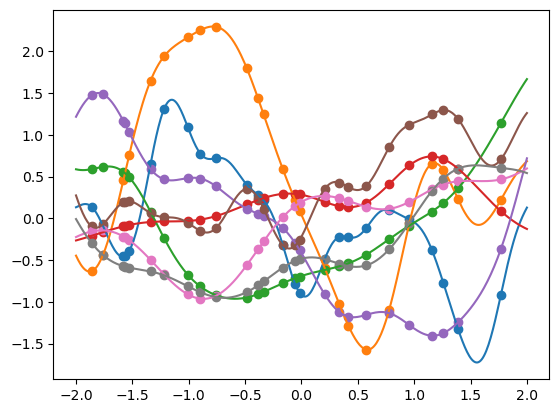

In [37]:
from data.datasets2 import GPData
import matplotlib.pyplot as plt

dataset = GPData(max_num_context=97)

batch = dataset.generate_batch(batch_size=8, testing=True)
for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target, y_target)
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context, y_context)
plt.show()

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

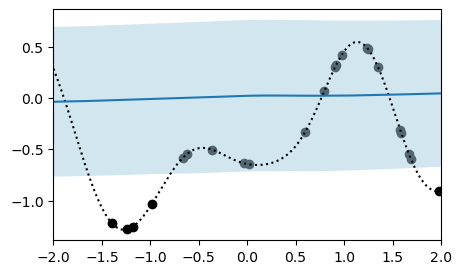

iter 1001: Avg. Loss = 54.089444202423095
iter 2001: Avg. Loss = 40.299978239655495
iter 3001: Avg. Loss = 38.93780588436127
iter 4001: Avg. Loss = 38.45759492170811
iter 5001: Avg. Loss = 38.247628090023994
iter 6001: Avg. Loss = 37.18703586256504
iter 7001: Avg. Loss = 38.04740505871177
iter 8001: Avg. Loss = 37.3526250474453
iter 9001: Avg. Loss = 38.15894591403008
iter 10001: Avg. Loss = 38.23563523030281
iter 10001: Avg. Loss SLOW = 399.01409845122697
iter 11001: Avg. Loss = 37.83893816125393
iter 12001: Avg. Loss = 37.07972539758682
iter 13001: Avg. Loss = 38.33251662826538
iter 14001: Avg. Loss = 36.9080356413126
iter 15001: Avg. Loss = 37.77726851415634
iter 16001: Avg. Loss = 36.87856472611427
iter 17001: Avg. Loss = 37.441881565332416
iter 18001: Avg. Loss = 37.338827339410784
iter 19001: Avg. Loss = 36.82706701822579
iter 20001: Avg. Loss = 36.01976496624947
iter 20001: Avg. Loss SLOW = 372.4425899579078


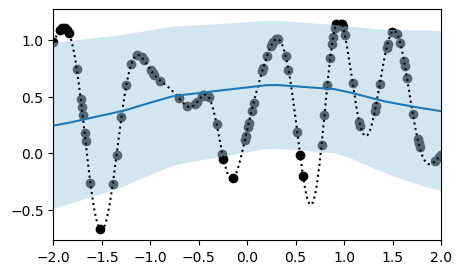

iter 21001: Avg. Loss = 36.077025617361066
iter 22001: Avg. Loss = 37.29323879122734
iter 23001: Avg. Loss = 35.750804293558005
iter 24001: Avg. Loss = 33.053682588279244
iter 25001: Avg. Loss = 30.855215536385774
iter 26001: Avg. Loss = 30.74167926056683
iter 27001: Avg. Loss = 30.45994171586633
iter 28001: Avg. Loss = 30.09274172323942
iter 29001: Avg. Loss = 31.278800618693232
iter 30001: Avg. Loss = 29.04529928971827
iter 30001: Avg. Loss SLOW = 324.6484294348955
iter 31001: Avg. Loss = 29.652474146410825
iter 32001: Avg. Loss = 29.625709652125835
iter 33001: Avg. Loss = 29.6454927829206
iter 34001: Avg. Loss = 29.36690564508736
iter 35001: Avg. Loss = 29.86493707165122
iter 36001: Avg. Loss = 28.841547050714492


In [46]:
import torch
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=1e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data = GPData(max_num_context=97)
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss = np(batch.x_context, batch.y_context, batch.x_target, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()